In [73]:
import numpy as np
import pandas as pd
import meanreversion as mr
import matplotlib.pyplot as plt

import meanreversion as mr

In [82]:
# Load asset data
df = mr.load_asset("data/DJ_M15_202009240845_202411131015.csv")
df = df.set_index(pd.DatetimeIndex(df['AbsTime'].values))
df.drop(['AbsTime'], inplace = True, axis = 1)

# Compute moving averages, returns, and ratios
window = 100
df['MA'] = df['Close'].rolling(window=100).mean()
df['Simple_Returns'] = df.pct_change(1)['Close']
df['Log_Returns'] = np.log(1+df['Simple_Returns'])
df['Ratios'] = mr.rectifiy_price(df, "Close", window=window)

# Compute rolling percentiles of the ratios
percentiles = [15, 50, 85]
for p in percentiles:
	df[f'perc_{p}'] =df["Ratios"].rolling(window=len(df)//20).quantile(p/100)

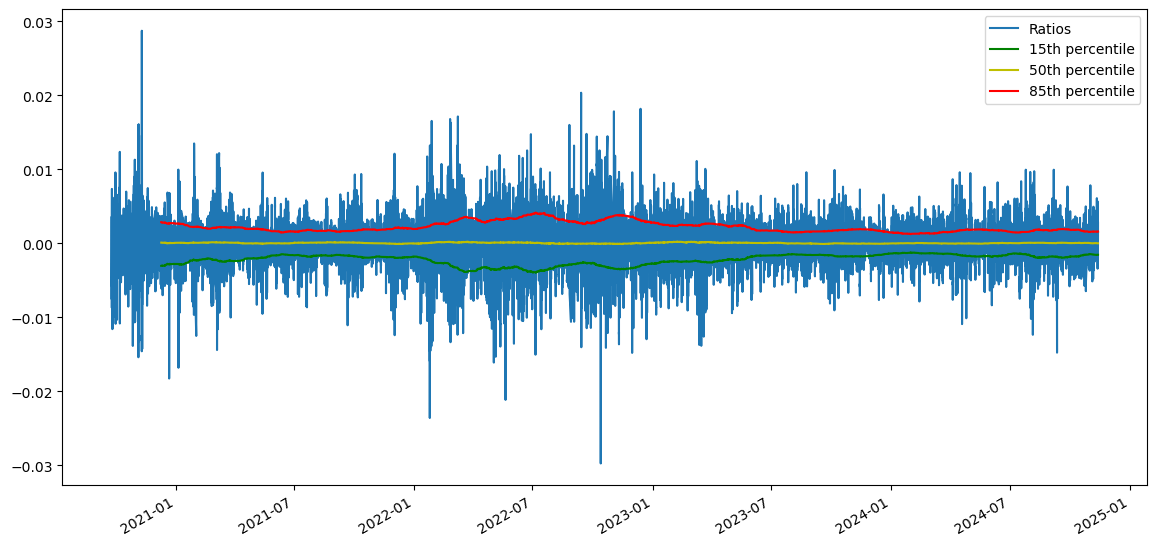

In [83]:
plt.figure(figsize=(14,7))
df['Ratios'].dropna().plot(legend = True)
plt.plot(df['perc_15'], c='g', label = '15th percentile')
plt.plot(df['perc_50'], c='y', label = '50th percentile')
plt.plot(df['perc_85'], c='r', label = '85th percentile')
plt.legend()
plt.show()

In [84]:
# Test with constant MRI indexes
# TODO: replace with real MRI rolling indexes
df['MRI'] = 1.0
# df.loc[(df.index >= '2021-01-01') & (df.index < '2021-01-01'), 'MRI'] = 2 
# df.loc[(df.index >= '2022-01-01') & (df.index < '2023-01-01'), 'MRI'] = 0.5 
# df.loc[(df.index >= '2023-01-01') & (df.index < '2025-01-01'), 'MRI'] = 1

# Buy and sell signals: buy (+1) when the ratio is below the 15th percentile, sell (-1) when it is above the 85th percentile
df['Positions'] = np.where(df.Ratios > df['perc_85'], -1, 0)
df['Positions'] = np.where(df.Ratios < df['perc_15'], 1, df['Positions'])
df['Positions'] = df['Positions'].ffill()

# Compute current and previous buy and sell prices
df['Buy'] = np.where(df['Positions'] == 1 , df['Close'], np.nan)
df['Sell'] = np.where(df['Positions'] == -1 , df['Close'], np.nan)
df['Previous_Buy'] = df['Buy'].shift(1)
df['Previous_Sell'] = df['Sell'].shift(1) 

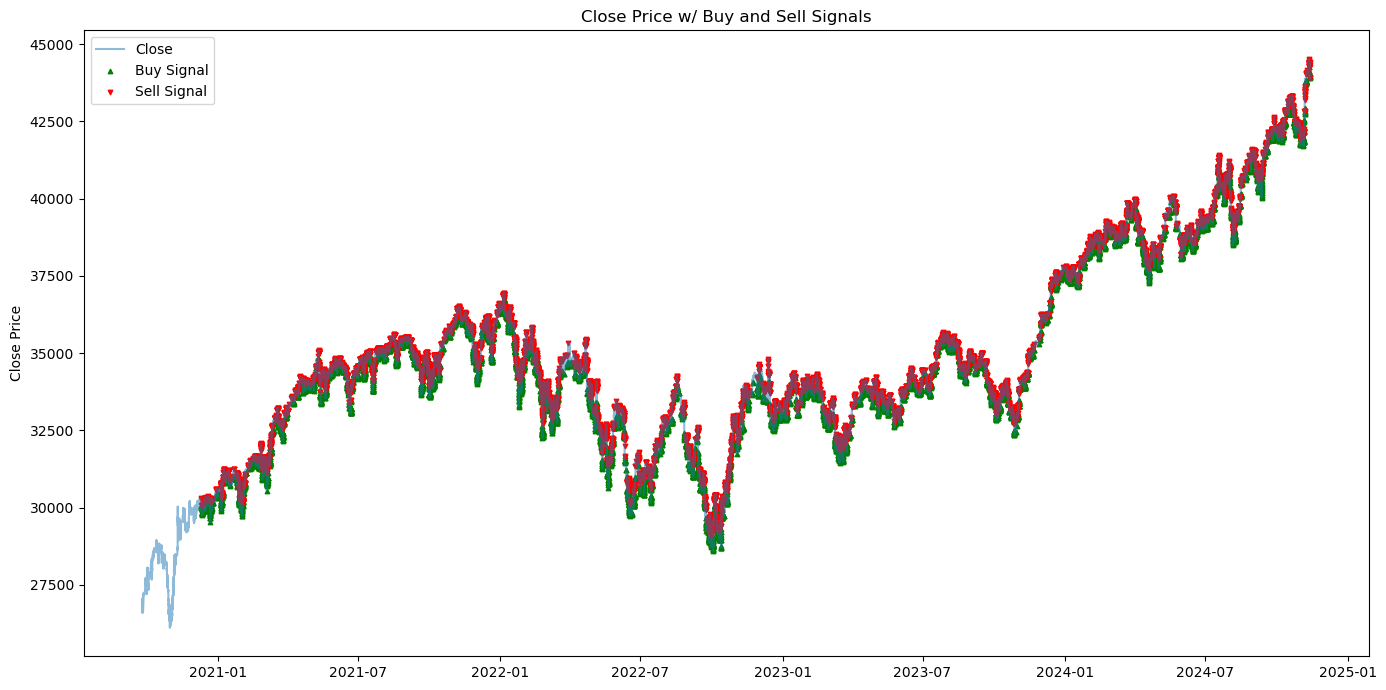

In [85]:
fig, axes = plt.subplots(1, 1, figsize=(14, 7))
axes.set_title('Close Price w/ Buy and Sell Signals')
axes.plot(df['Close'], alpha=0.5, label='Close')
axes.scatter(df.index, df['Buy'], c='g', label='Buy Signal', marker='^', s=10)
axes.scatter(df.index, df['Sell'], c='r', label='Sell Signal', marker='v', s=10)
axes.set_ylabel('Close Price')
axes.legend()
plt.tight_layout()
plt.show()

Total Buy Signals: 13685
Total Sell Signals: 13711
Total Euro Invested: 13719.86322804313
Total percentual profit: 0.94%


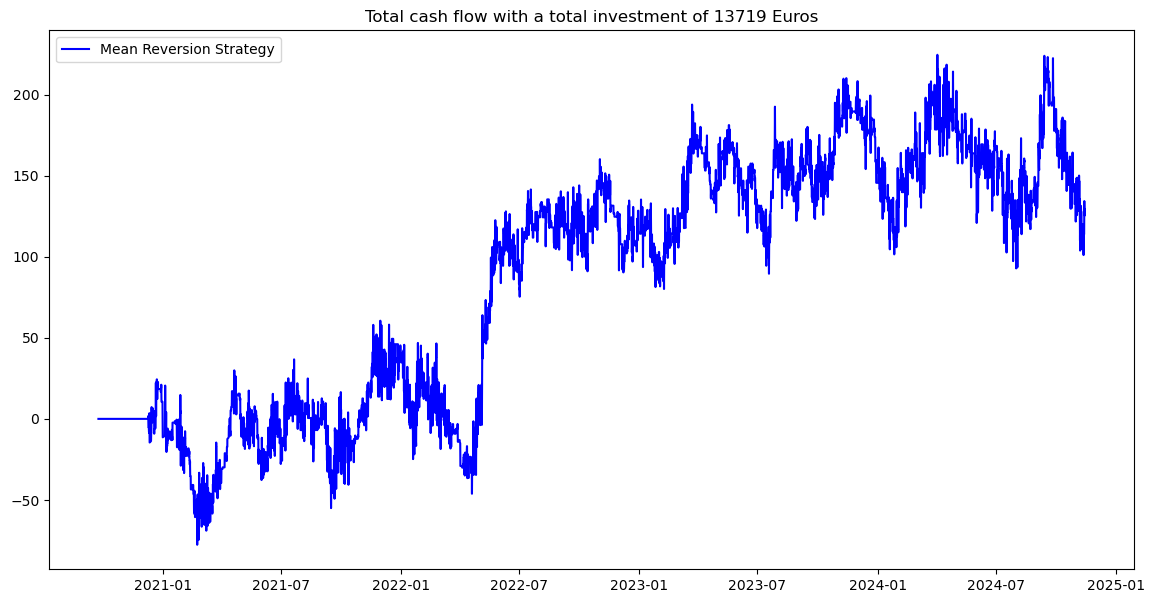

In [86]:
def apply_trading_strategy(df):
    mv = df['Close'].mean()
    #Compute weighted strategy
    df['Investment'] = np.where(df['Buy'].notna(), df['Buy'] / mv * df['MRI'], 0)
    df['Revenue'] = np.where(df['Sell'].notna(), df['Sell'] / mv * df['MRI'], 0)
    df['Trade_Profit'] = df['Revenue'] - df['Investment']
    df['Cum_Profit'] = df['Trade_Profit'].cumsum()

    #Count buy/sell signals
    num_buys = df['Buy'].count()
    num_sells = df['Sell'].count()
    print(f"Total Buy Signals: {num_buys}")
    print(f"Total Sell Signals: {num_sells}")

    #Calculate total investment
    df['Investment_Per_Buy'] = df['Buy'] / mv
    total_investment = df['Investment_Per_Buy'].sum()
    print(f"Total Euro Invested: {total_investment}")

    #Compute and print total percentual profit
    total_profit_percent = df['Cum_Profit'].iloc[-1] / total_investment * 100
    print(f"Total percentual profit: {total_profit_percent:.2f}%")

    #Plot results
    plt.figure(figsize=(14,7))
    plt.title(f'Total cash flow with a total investment of {int(total_investment)} Euros')
    plt.plot(df['Cum_Profit'].dropna(), c='b', label='Mean Reversion Strategy')
    plt.legend()
    plt.show()

    return None

# Apply trading strategy
apply_trading_strategy(df)

### Normality test approach

In [104]:
# Quite lengthy calculation
# TODO: reduce the size of the dataset
df["MRI"] = df["Ratios"].rolling(window = 1000, center = False).apply(mr.assess_normality_rolling, raw=True, args = (int(1000/10),) )

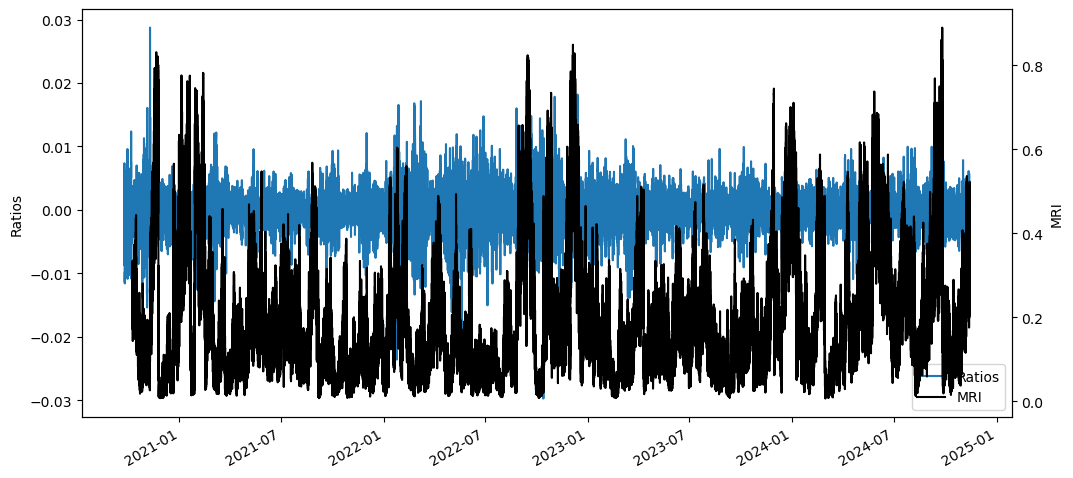

Total Buy Signals: 13685
Total Sell Signals: 13711
Total Euro Invested: 13719.86322804313
Total percentual profit: 0.05%


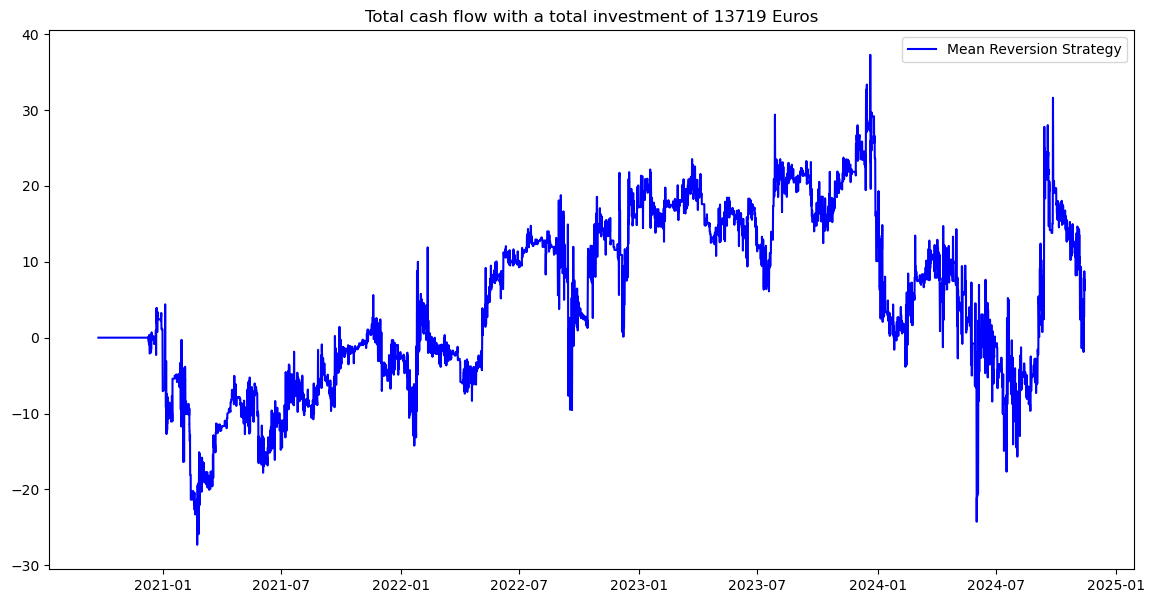

In [105]:
#df['MRI'] = mr.savgol(df['MRI'], window_length=5000, polyorder=3) # Smoothing
ax = df["Ratios"].plot(figsize=(12,6), label="Ratios")
ax2 = ax.twinx()
df["MRI"].plot(ax=ax2, color='k', label="MRI")
ax.set_ylabel("Ratios")
ax2.set_ylabel("MRI")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
ax.set_xlabel("")
ax.set_ylabel("Ratios")
ax2.set_ylabel("MRI")
plt.show()

apply_trading_strategy(df)

### Daily datapoints for stochastic approach

[*********************100%***********************]  1 of 1 completed

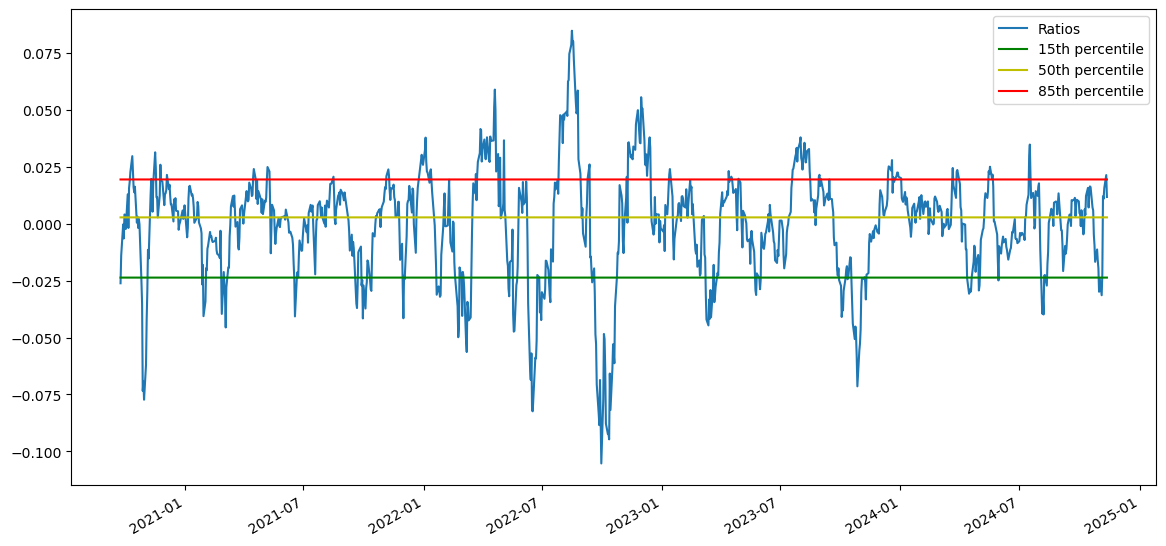

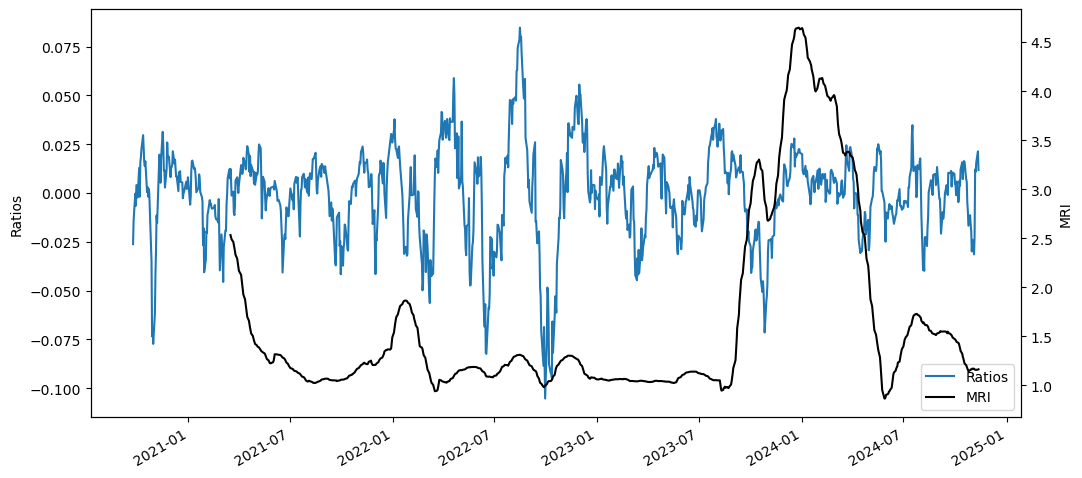

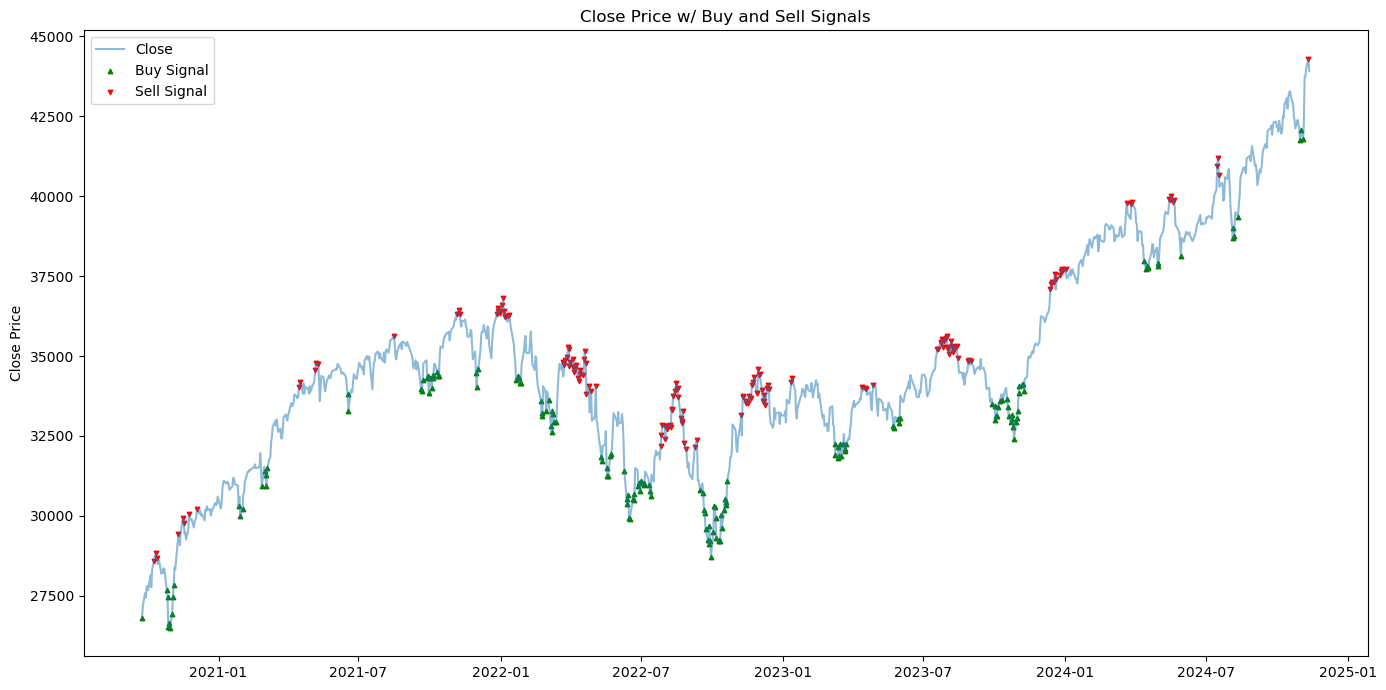

Total Buy Signals: 156
Total Sell Signals: 156
Total Euro Invested: 146.1041952187568
Total percentual profit: 17.41%


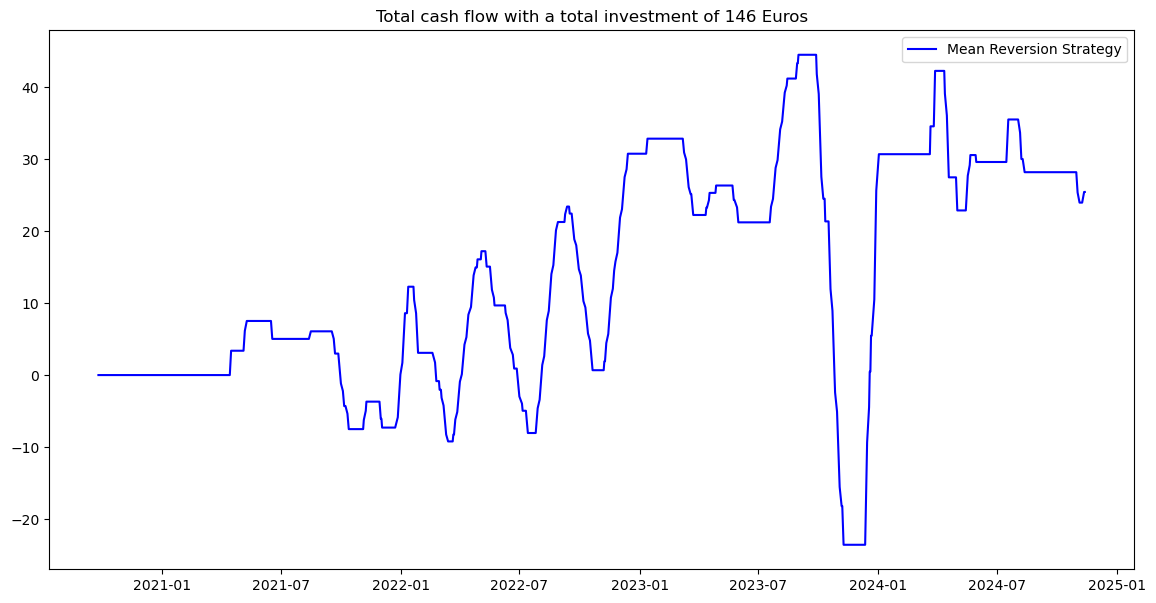

In [119]:
# Download asset data
df = mr.download_asset("^DJI", start='2020-09-24',end='2024-11-13')
df = df.set_index(pd.DatetimeIndex(df['AbsTime'].values))
df.drop(['AbsTime'], inplace = True, axis = 1)

# Compute moving averages, returns, and ratios
window = 100
df['MA'] = df['Close'].rolling(window=100).mean()
df['Simple_Returns'] = df.pct_change(1)['Close']
df['Log_Returns'] = np.log(1+df['Simple_Returns'])
df['Ratios'] = mr.rectifiy_price(df, "Close", window=window)

# Compute percentiles of the ratios (not rolling, not enough data)
percentiles = [15, 50, 85]
for p in percentiles:
	df[f'perc_{p}'] =df["Ratios"].quantile(p/100)


plt.figure(figsize=(14,7))
df['Ratios'].dropna().plot(legend = True)
plt.plot(df['perc_15'], c='g', label = '15th percentile')
plt.plot(df['perc_50'], c='y', label = '50th percentile')
plt.plot(df['perc_85'], c='r', label = '85th percentile')
plt.legend()
plt.show()

# TODO: change normalization function, penalize to much low mean reversion
# also, weighting more higher values of MRI (buying more with MRI close to 1) give much better results
# I have shifted MRI index to buy more
df['MRI'] = (df["Ratios"].rolling(window=120, center=False).apply(mr.mean_revertion_index, raw=True)+0.2)*5
df['MRI'] = mr.savgol(df['MRI'], window_length=60, polyorder=3)

# df['MRI'] = 1.0
# df.loc[(df.index >= '2021-01-01') & (df.index < '2021-01-01'), 'MRI'] = 2 
# df.loc[(df.index >= '2022-01-01') & (df.index < '2023-01-01'), 'MRI'] = 0.5 
# df.loc[(df.index >= '2023-01-01') & (df.index < '2025-01-01'), 'MRI'] = 1

# Buy and sell signals: buy (+1) when the ratio is below the 15th percentile, sell (-1) when it is above the 85th percentile
df['Positions'] = np.where(df.Ratios > df['perc_85'], -1, 0)
df['Positions'] = np.where(df.Ratios < df['perc_15'], 1, df['Positions'])
df['Positions'] = df['Positions'].ffill()

# Compute current and previous buy and sell prices
df['Buy'] = np.where(df['Positions'] == 1 , df['Close'], np.nan)
df['Sell'] = np.where(df['Positions'] == -1 , df['Close'], np.nan)
df['Previous_Buy'] = df['Buy'].shift(1)
df['Previous_Sell'] = df['Sell'].shift(1) 

ax = df["Ratios"].plot(figsize=(12,6), label="Ratios")
ax2 = ax.twinx()
df["MRI"].plot(ax=ax2, color='k', label="MRI")
ax.set_ylabel("Ratios")
ax2.set_ylabel("MRI")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
ax.set_xlabel("")
ax.set_ylabel("Ratios")
ax2.set_ylabel("MRI")
plt.show()


fig, axes = plt.subplots(1, 1, figsize=(14, 7))
axes.set_title('Close Price w/ Buy and Sell Signals')
axes.plot(df['Close'], alpha=0.5, label='Close')
axes.scatter(df.index, df['Buy'], c='g', label='Buy Signal', marker='^', s=10)
axes.scatter(df.index, df['Sell'], c='r', label='Sell Signal', marker='v', s=10)
axes.set_ylabel('Close Price')
axes.legend()
plt.tight_layout()
plt.show()

apply_trading_strategy(df)